In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from ipywidgets import widgets
import ConfigReader as cr

In [107]:
reload(cr)

<module 'ConfigReader' from 'ConfigReader.py'>

In [2]:
#Styles
sns.set_style('darkgrid')
sns.set_color_codes()
plt.rcParams['figure.figsize'] = (12.0, 9.0)

plt.rc('text', usetex=False)
plt.rc('font', size=20.0, family='serif')

In [3]:
# Data location and dataset
dataset = '554_bac'

In [4]:
reader = cr.ConfigReader(dataset=dataset)

In [67]:
base_data_dir = '/mhome/mendozah/constrained_DeepNet_Configs/'
solvers = ['adam', 'adadelta', 'adagrad', 'nesterov', 'sgd', 'momentum']
policies = ['fixed', 'inv', 'exp', 'step']
interesting_params = [ 'response', 'solver', 'learning_rate', 'beta1', 'beta2', 'momentum',
                      'lambda2', 'lr_policy','gamma', 'power', 'epoch_step']

In [107]:
policy_solver_mean = []
policy_solver_sem = []
params_frame = []
for j in solvers:
    mean_list = []
    sem_list = []
    params_list = []
    for i in policies:
        data_dir = base_data_dir + j + '_results/' + i
        _, bdf = reader.load_run_configs(data_dir=data_dir, preprocessor=None)
        params_list.append(bdf.ix[:, interesting_params])
        mean_list.append(bdf.response.mean())
        sem_list.append(bdf.response.sem())
    solver_mean = np.array(mean_list)
    solver_sem = np.array(sem_list)
    policy_solver_mean.append(solver_mean)
    policy_solver_sem.append(solver_sem)
    params_frame.append(pd.concat(params_list,axis=0))

mean_df = pd.DataFrame(policy_solver_mean, index=solvers, columns=policies)
sem_df = pd.DataFrame(policy_solver_sem, index=solvers, columns=policies)
params_df = pd.concat(params_frame)
params_df.loc[:, 'lr_policy'] = params_df.ix[:,'lr_policy'].fillna('fixed')
params_df = params_df.apply(pd.to_numeric, errors='ignore')

In [69]:
mean_df.applymap(lambda X: "{:.6f}".format(X)) + ' ± ' +sem_df.applymap(lambda x: "{:.6f}".format(x))

,fixed,inv,exp,step
adam,0.020840 ± 0.001305,0.018825 ± 0.000873,0.025419 ± 0.001084,0.021653 ± 0.001454
adadelta,0.034418 ± 0.009656,0.056148 ± 0.013279,0.093845 ± 0.014883,0.044387 ± 0.011645
adagrad,0.023592 ± 0.001431,0.025951 ± 0.001655,0.032176 ± 0.002376,0.022693 ± 0.000938
nesterov,0.027363 ± 0.001997,0.039485 ± 0.003475,0.057317 ± 0.005833,0.044414 ± 0.006226
sgd,0.036222 ± 0.006815,0.040874 ± 0.001807,0.074779 ± 0.013164,0.040173 ± 0.003668
momentum,0.028253 ± 0.003903,0.036344 ± 0.002968,0.058095 ± 0.005365,0.047284 ± 0.007990


<function __main__.bar_policy>

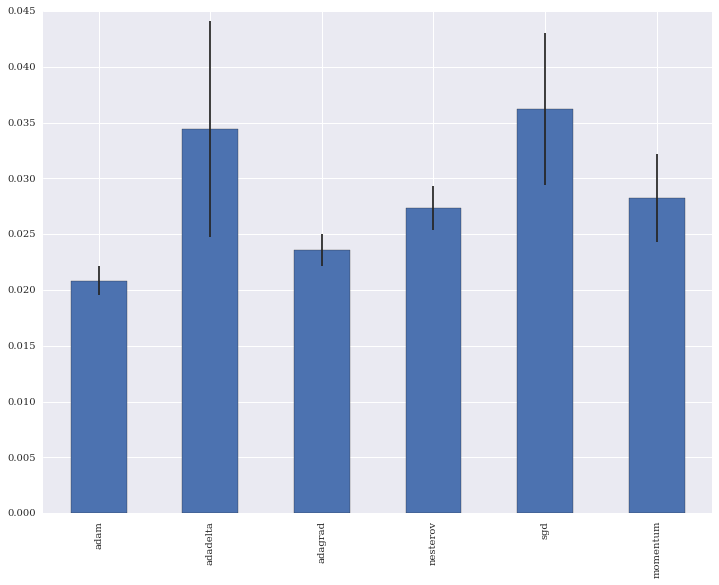

In [70]:
def bar_policy(policies):
    mean_df[policies].plot(kind='bar', yerr=sem_df[policies])

widgets.interact(bar_policy, policies=policies)

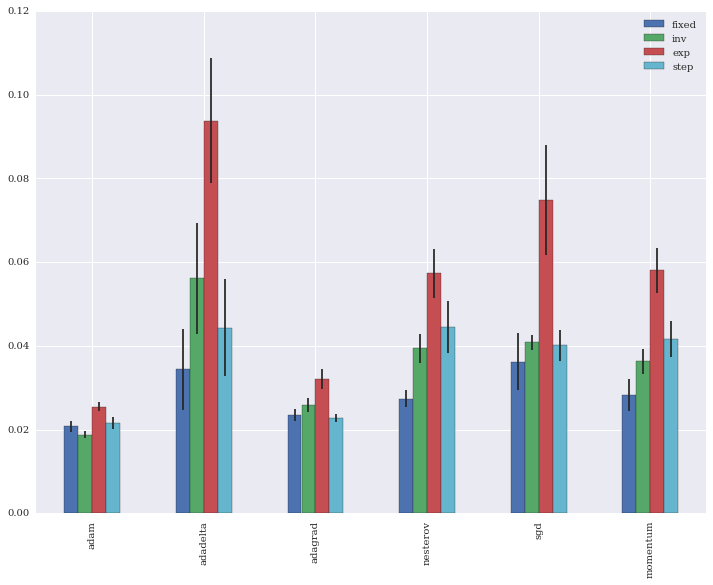

In [108]:
mean_df.plot(kind='bar', yerr=sem_df)

In [110]:
# Rescale values in log-scale
params_rescale = ['learning_rate','lambda2', 'beta1', 'beta2']
params_df.loc[:,params_rescale]=params_df.ix[:,params_rescale].applymap(lambda x: np.log10(x))

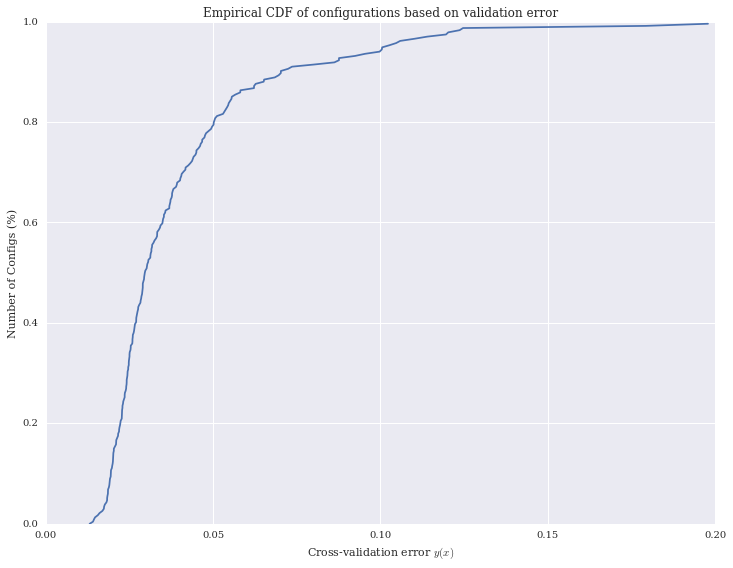

In [73]:
# Plot the empirical CDF
sorted_Y = (params_df.sort_values(by='response', ascending=True)['response'].values)
yvals = np.arange(len(sorted_Y)) / float(len(sorted_Y))

plt.plot( sorted_Y, yvals )
plt.xlabel("Cross-validation error $y(x)$")
plt.ylabel(r"Number of Configs (%)")
plt.xlim(0.0, 0.2)
plt.title("Empirical CDF of configurations based on validation error")
plt.show()

## After Setting the frames. Start with the plotting

In [74]:
## TODO: Review how to make filtered and the figure return
def plotting_threshold(error_threshold, categories):
    #global filtered
    filtered = params_df[params_df.response <= error_threshold]
    fig_f, axs = plt.subplots(ncols=2,nrows=1, figsize=(15.0, 8.5))
    ax0, ax1 = axs.flat
    sns.boxplot(x=categories, y='response', data=filtered, ax=ax0)
    sns.countplot(y=categories, data=filtered, ax=ax1)
    fig_f.tight_layout()

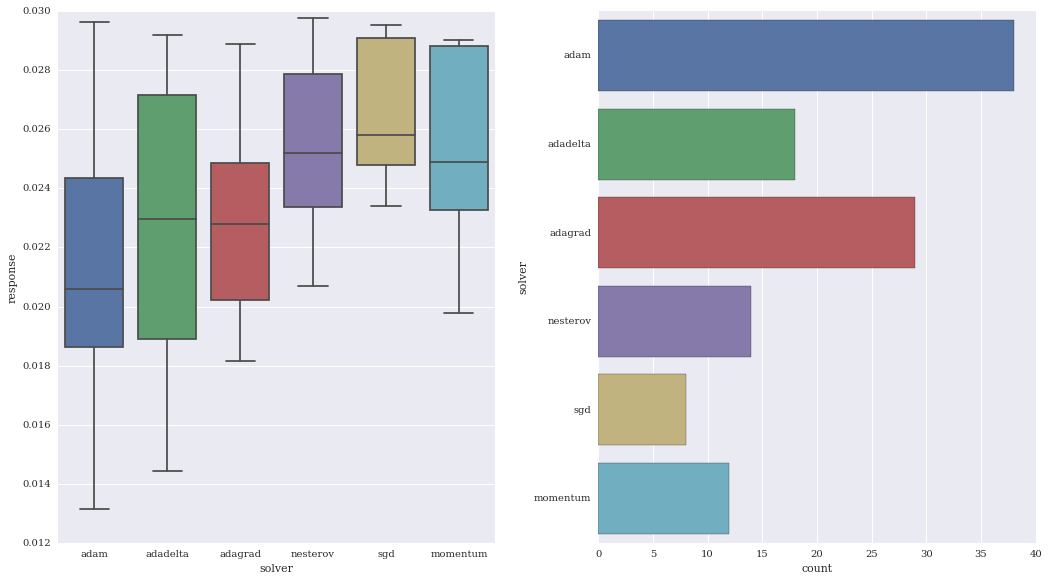

In [75]:
widgets.interact(plotting_threshold, error_threshold=(0.01,0.2,0.01),
                 categories={'Solver':'solver', 'Policy':'lr_policy'})

In [76]:
# Create the grouping of the filtered DF
solver_filt = params_df.groupby('solver')

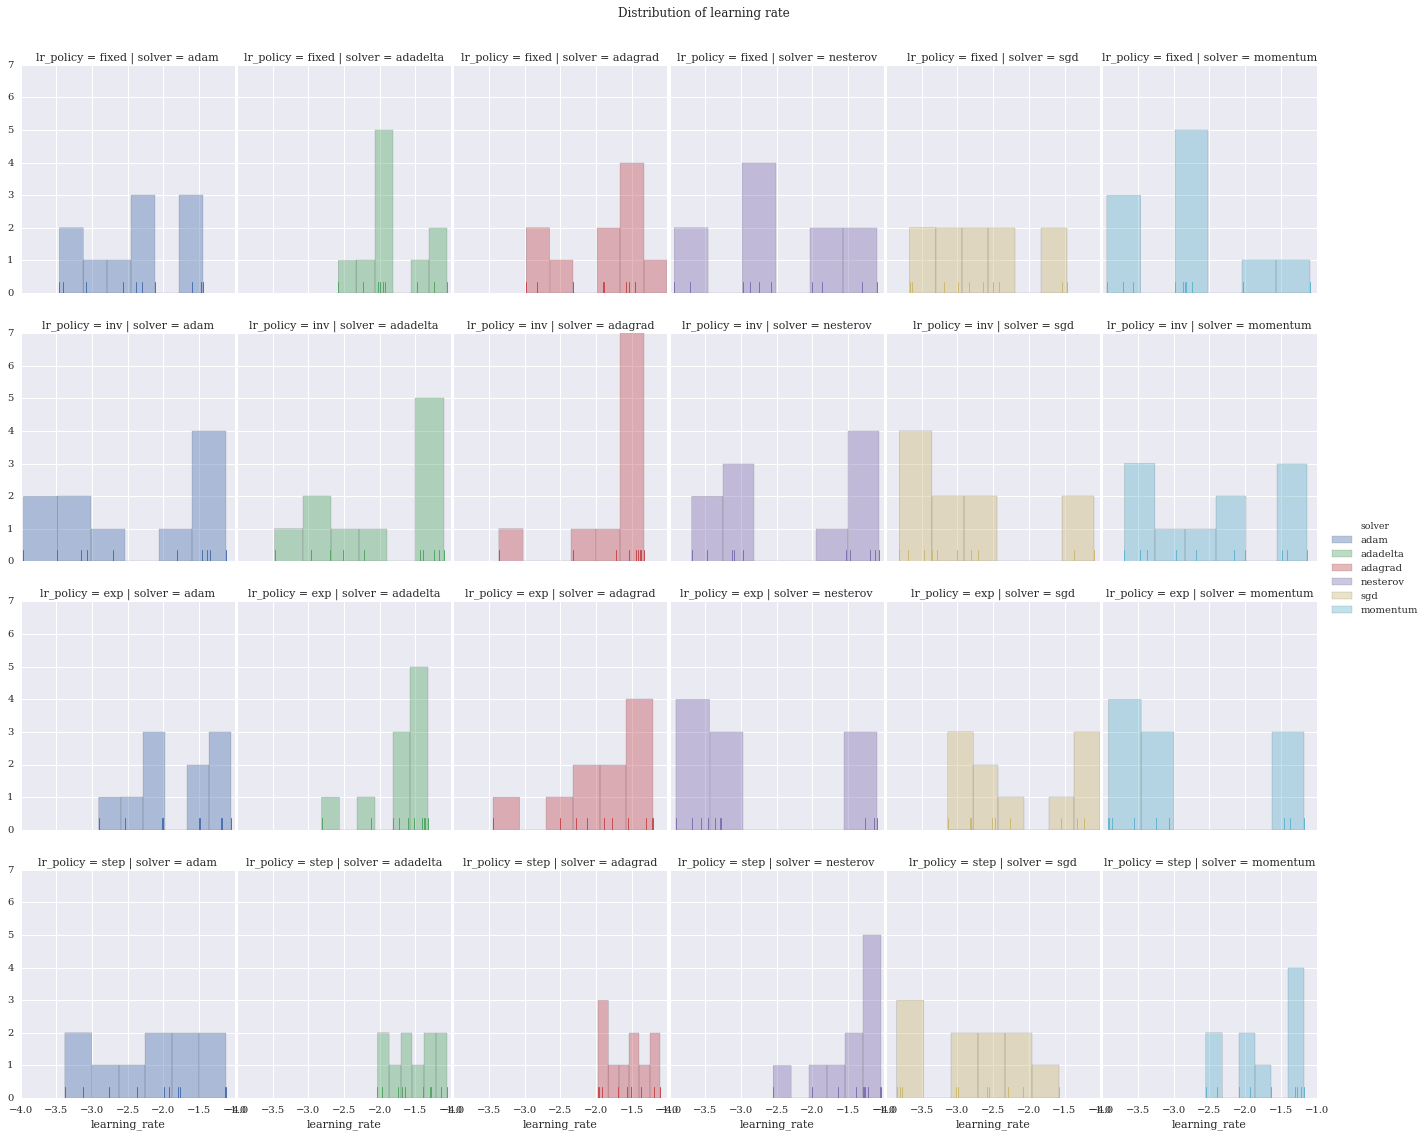

In [135]:
g_barGrid = sns.FacetGrid(data=params_df, col='solver', row='lr_policy', hue='solver',
                              size=3.9, aspect=0.8)
g_barGrid.map(sns.distplot, 'learning_rate', hist=True, kde=False, rug=True, bins=6)
g_barGrid.add_legend()
g_barGrid.fig.suptitle('Distribution of learning rate',
                           fontsize=12, y=1.02)
g_barGrid.fig.subplots_adjust(wspace=.01,)
g_barGrid.fig.savefig('images/distro_lr_solver_vs_policy.png')

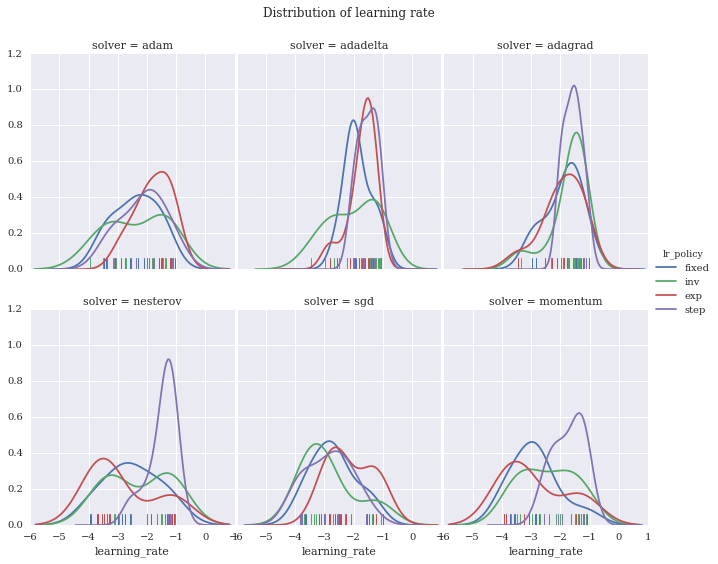

In [161]:
g_kdeGrid = sns.FacetGrid(data=params_df, col='solver', hue='lr_policy',
                          col_wrap=3, size=3.9, aspect=0.8)
g_kdeGrid.map(sns.distplot, 'learning_rate', hist=False, kde=True, rug=True)
g_kdeGrid.add_legend()
g_kdeGrid.fig.suptitle('Distribution of learning rate',
                           fontsize=12, y=1.02)
g_kdeGrid.fig.subplots_adjust(wspace=.01,)
g_kdeGrid.fig.savefig('images/kde_lr_solver.png')

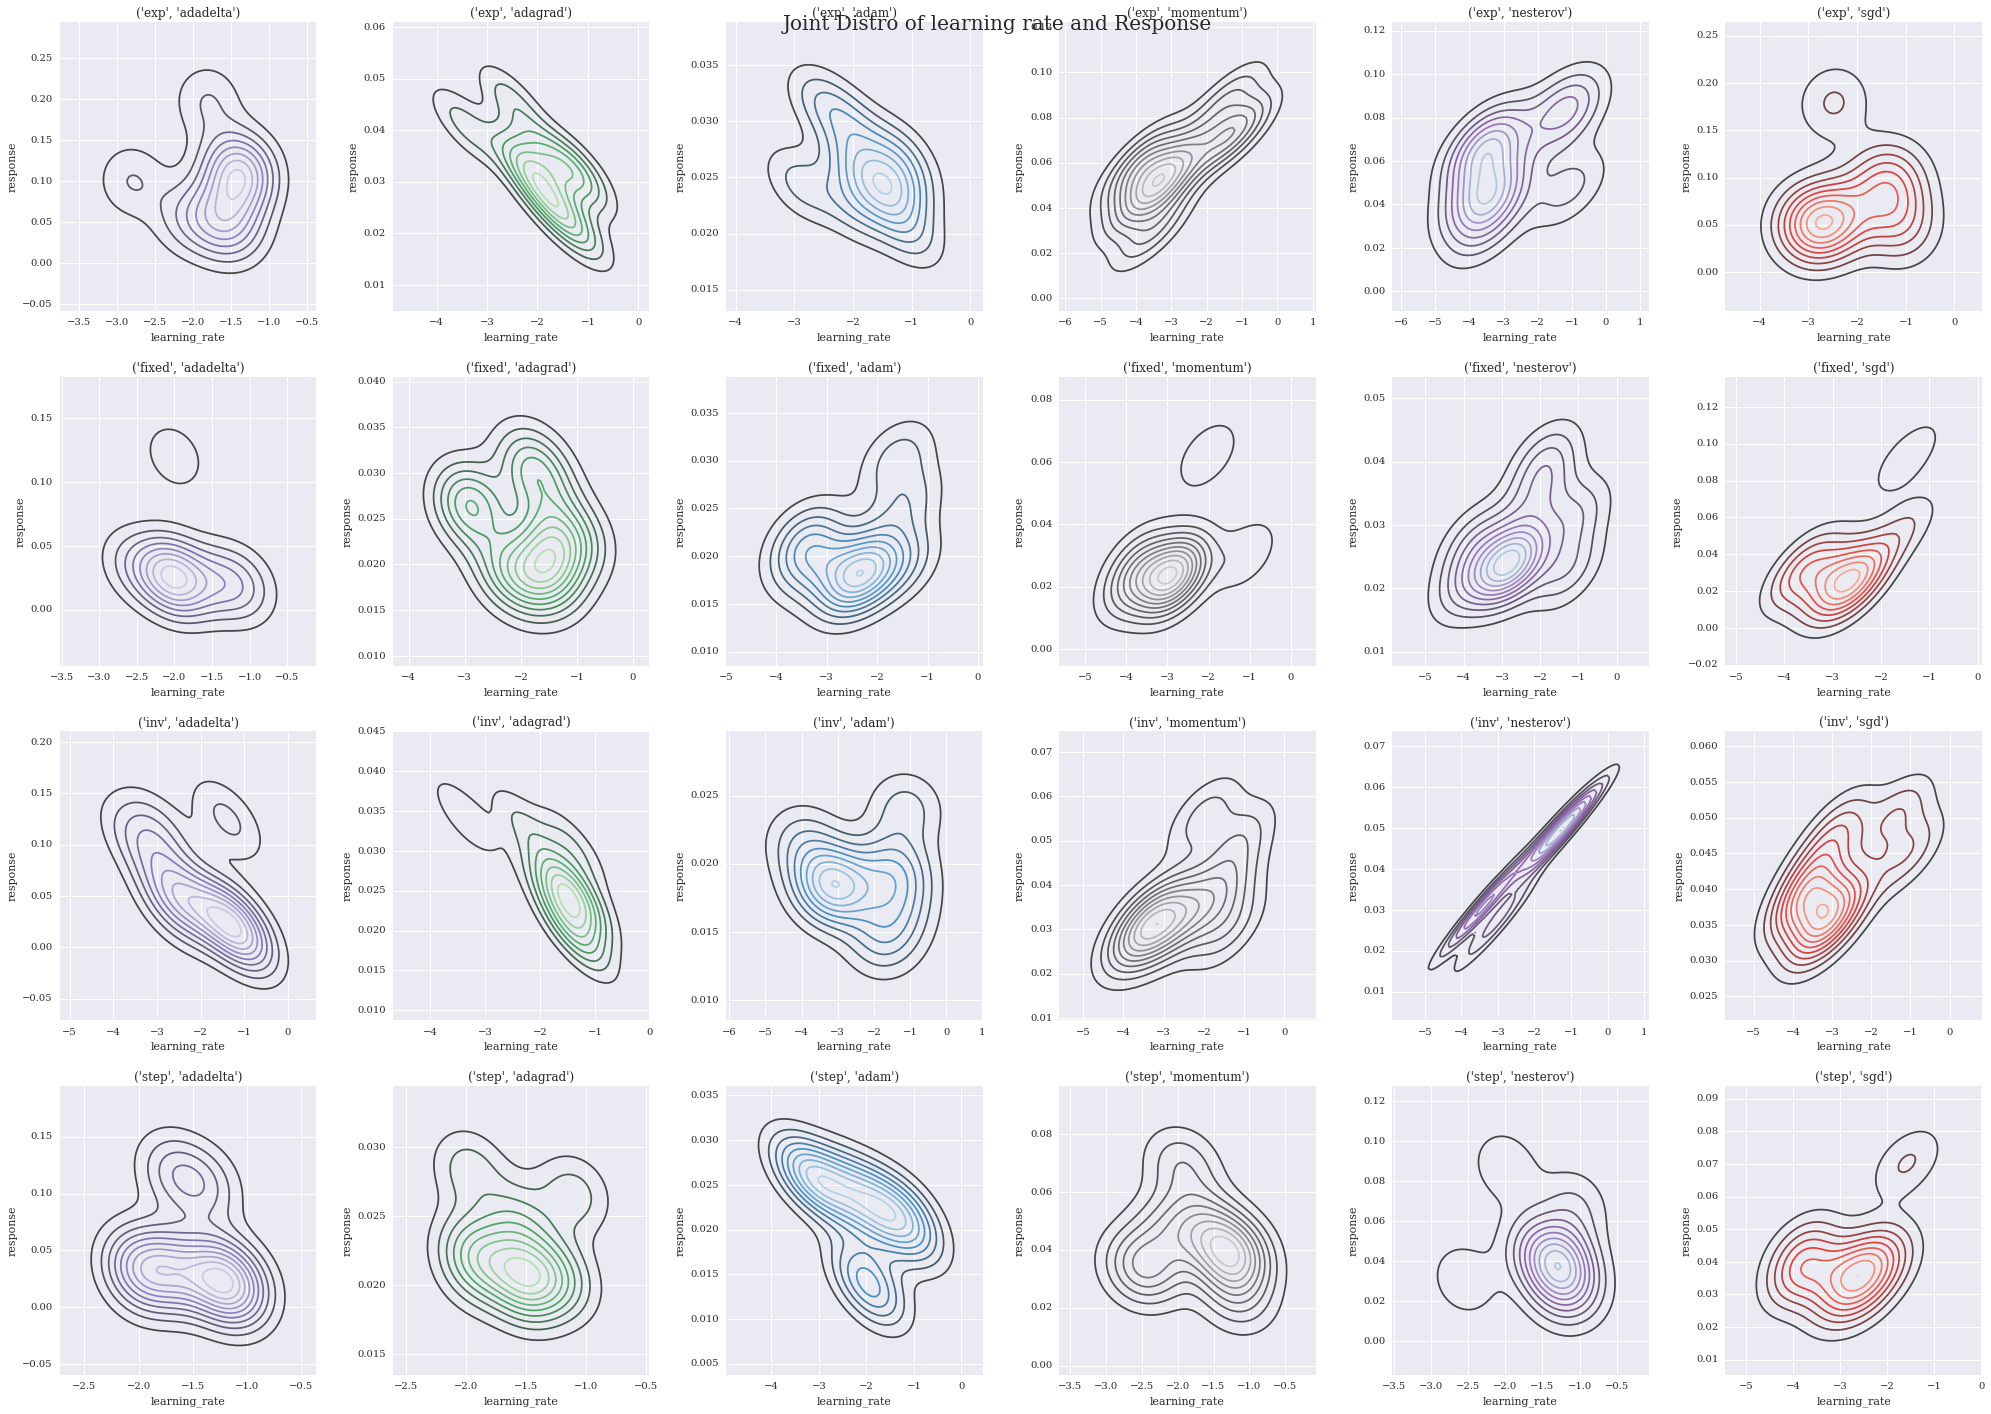

In [183]:
color_maps = ['Blues_d', 'Purples_d', 'Greens_d', 'BuPu_d', 'Reds_d', 'Greys_d']
cmaps_ = dict(zip(solvers, color_maps))

g = params_df.groupby(['lr_policy', 'solver'])
s = len(g)
fig_kde, axs = plt.subplots(nrows=int(np.ceil(s/6.)), ncols=6, figsize=(28., 20.))
for ax, (name, groups) in zip(axs.flat,g):
    sns.kdeplot(groups['learning_rate'].dropna().values, groups['response'].dropna().values,
                label=name, alpha=0.9, ax=ax, cmap=cmaps_.get(name[1]))
    ax.set_xlabel('learning_rate')
    ax.set_ylabel('response')
    ax.set_title(name)
    ax.legend()
fig_kde.suptitle('Joint Distro of learning rate and Response')
fig_kde.savefig('images/joint_distro_lr_response.png')
plt.tight_layout()

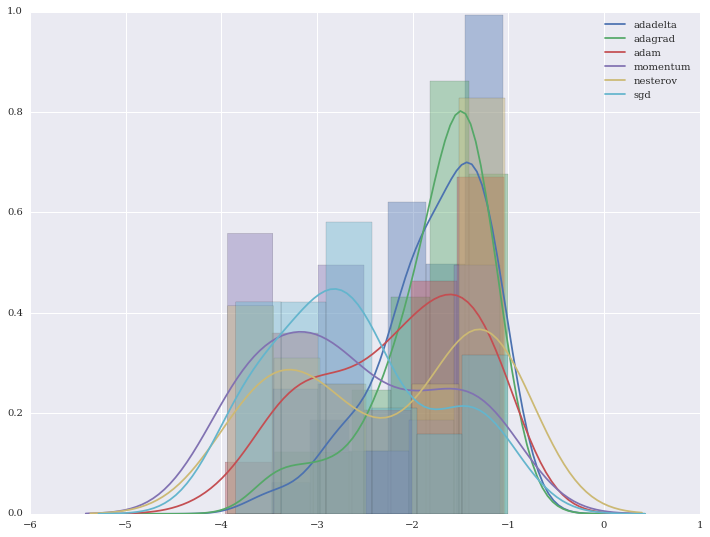

In [153]:
# Seaborns Normed Distribution plots
for name,groups in solver_filt:
    sns.distplot(groups.learning_rate.values, bins=6, kde_kws={'label':name})

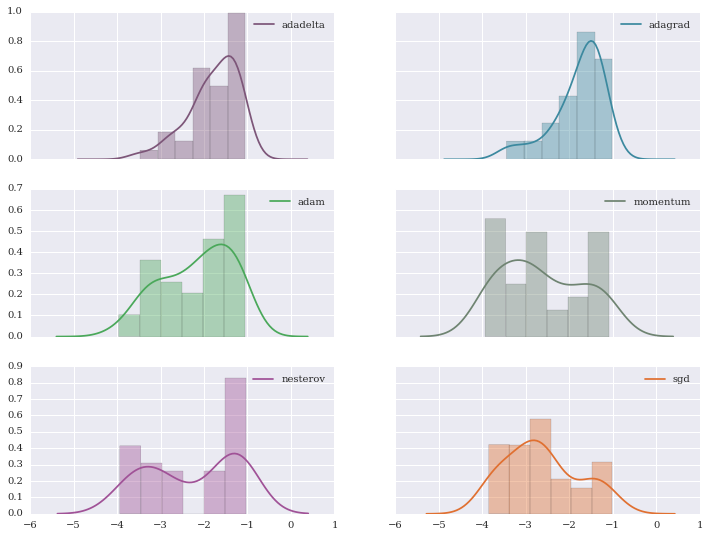

In [115]:
#Subplots of the previous histogram
color_histograms = sns.color_palette('Set1_r',12, desat=1.0)
fig1, axs = plt.subplots(nrows=3, ncols=2, sharey='row', sharex=True)
for iterate_axis, (name, groups) in zip(axs.flat, solver_filt):
    sns.distplot(groups.learning_rate.values, bins=6, kde_kws={'label':name},
                 color=color_histograms.pop(), ax=iterate_axis)
    iterate_axis.legend()

In [118]:
# Create the grouping of the filtered DF
prepro_filt = params_df.groupby('lr_policy')

In [131]:
def histogram_group_column_plotting(grouping, column):
    #Have to convert the -1 to NaN
    g = params_df.groupby(grouping)
    s = len(g)
    col_hist = sns.color_palette('Paired',s, desat=0.8)
    fig_hist, axs = plt.subplots(nrows=int(np.ceil(s/2.)), ncols=2, sharex='col', sharey='row', figsize=(15., 11.))
    for ax, (name, groups) in zip(axs.flat,g):
        ax.hist(groups[column].dropna().values, bins=15,
                histtype='bar', fill=True, label=name, alpha=0.9, color=col_hist.pop())
        ax.set_xlabel(column + ' values')
        ax.set_ylabel('# of Configs')
        ax.legend()
    fig_hist.suptitle('Distribution of '+ column +' values for each '+(grouping))

In [127]:
# Create columns dict
Groups = ['solver','lr_policy']
Plott = {'Learning Rate':'learning_rate', 'beta 1':'beta1', 'beta 2':'beta2',
         'Regularization Param':'lambda2', 'gamma':'gamma', 'power':'power', 'step size':'epoch_step'}

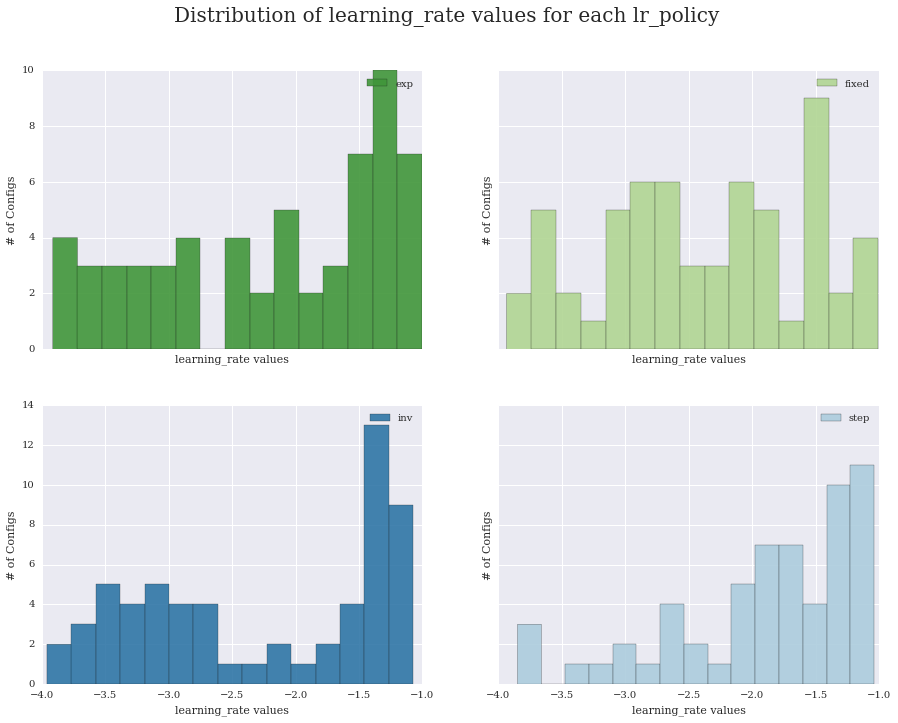

In [132]:
widgets.interact(histogram_group_column_plotting, grouping=Groups, column=Plott)

### Distribution of each parameter over all filtered configurations

In [129]:
def histogram_column_plotting(column):
    fig_hist = plt.figure(6)
    ax1 = plt.subplot(111)
    ax1.set_title('Histogram of '+column)
    params_df[column].plot(kind='hist', bins=15, ax=ax1)
    ax1.set_xlabel('values')

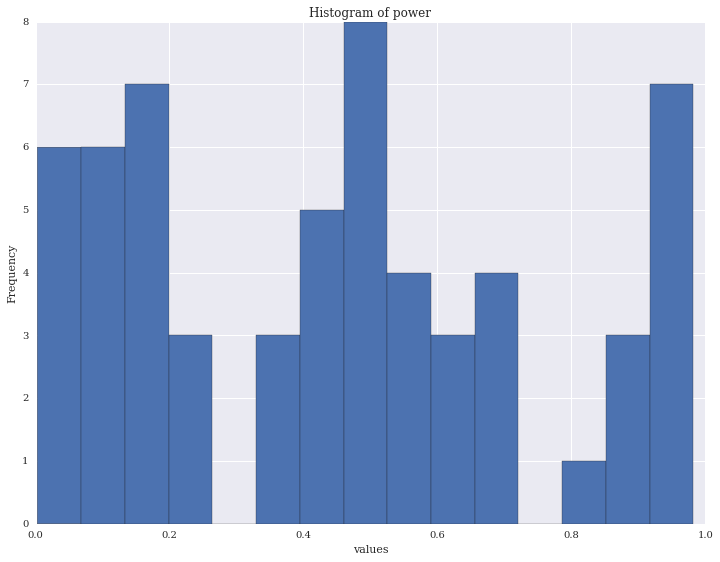

In [130]:
widgets.interact(histogram_column_plotting, column=list(params_df.columns.values[1:]))